## X-Ray Abnormality Detection | MobileNetV2, pretrained on ImageNet





In [ ]:
#kết nối với gg drive
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
#đặt thêm đường dẫn tìm kiếm
import sys
sys.path.append('/content/gdrive/My Drive')

In [ ]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.1 MB 8.0 MB/s 


In [ ]:
!unzip gdrive/MyDrive/MURA-v1.1.zip

In [ ]:
import os
import pathlib
import random
import re
from glob import glob

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_addons as tfa
from sklearn.metrics import cohen_kappa_score
from sklearn.utils import shuffle

from utils import (
    clean_up,
    F1Score,
    inspect_df,
    plot_metrics,
)


pd.set_option("max_colwidth", None)
#plt.style.use("dark_background") 'default'

In [ ]:
gpus = tf.config.experimental.list_physical_devices("GPU")

try:
    tf.config.experimental.set_memory_growth(gpus[0], True)
except IndexError:
    print("Cannot memory-restrict the GPU, if no GPU exists in system. Ignore...")
    pass

In [ ]:
SEED = 314

os.environ["PYTHONHASHSEED"] = str(SEED)
random.seed(SEED)
tf.random.set_seed(SEED)
np.random.seed(SEED)

### Data Loading

In [ ]:
DATASET_DIR = "/content/MURA-v1.1"

In [ ]:
train_image_paths = pd.read_csv(
    os.path.join(DATASET_DIR, "train_image_paths.csv"), #"train_image_paths.csv"
    names=["image_path"],
    header=None,
    index_col=False,
)

inspect_df(train_image_paths)

shape: (36808, 1)


,image_path
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png
1,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png
2,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png
3,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png
4,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png


In [ ]:
train_image_paths["image_path"] = train_image_paths["image_path"].map(
    lambda x: os.path.join("/content/", x)
)
train_image_paths["study_type"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[4]
)
train_image_paths["patient"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[5]
)
train_image_paths["study"] = train_image_paths["image_path"].map(
    lambda x: x.split("/")[6]
)
train_image_paths["study_path"] = train_image_paths["image_path"].map(
    lambda x: re.sub(r"image\d+.png", "", x)
)

In [ ]:
inspect_df(train_image_paths)

shape: (36808, 5)


,image_path,study_type,patient,study,study_path
0,/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
1,/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
2,/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/
3,/content/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,/content/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/
4,/content/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,/content/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/


In [ ]:
train_labeled_studies = pd.read_csv(
    os.path.join(DATASET_DIR, "train_labeled_studies.csv"), #"train_labeled_studies.csv"
    names=["study_path", "label"],
    header=None,
    index_col=False,
)

inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [ ]:
train_labeled_studies["study_path"] = train_labeled_studies["study_path"].map(
    lambda x: os.path.join("/content/", x)
)
train_labeled_studies["label"] = train_labeled_studies["label"].map(str)

In [ ]:
inspect_df(train_labeled_studies)

shape: (13457, 2)


,study_path,label
0,/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,/content/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
2,/content/MURA-v1.1/train/XR_SHOULDER/patient00003/study1_positive/,1
3,/content/MURA-v1.1/train/XR_SHOULDER/patient00004/study1_positive/,1
4,/content/MURA-v1.1/train/XR_SHOULDER/patient00005/study1_positive/,1


In [ ]:
ref_trainset = pd.merge(
    train_image_paths, train_labeled_studies, how="inner", on="study_path"
)

inspect_df(ref_trainset)

shape: (36808, 6)


,image_path,study_type,patient,study,study_path,label
0,/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image1.png,XR_SHOULDER,patient00001,study1_positive,/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
1,/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image2.png,XR_SHOULDER,patient00001,study1_positive,/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
2,/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/image3.png,XR_SHOULDER,patient00001,study1_positive,/content/MURA-v1.1/train/XR_SHOULDER/patient00001/study1_positive/,1
3,/content/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image1.png,XR_SHOULDER,patient00002,study1_positive,/content/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1
4,/content/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/image2.png,XR_SHOULDER,patient00002,study1_positive,/content/MURA-v1.1/train/XR_SHOULDER/patient00002/study1_positive/,1


#### Create a tensorflow input pipeline for the training data

In [ ]:
ref_trainset=ref_trainset[ref_trainset['study_type']=='XR_WRIST']

#loaistudy=['XR_ELBOW','XR_FINGER','XR_FOREARM','XR_HAND','XR_HUMERUS','XR_SHOULDER','XR_WRIST']


In [ ]:
IMAGE_WIDTH = IMAGE_HEIGHT = 224
BATCH_SIZE = 8
#chỉnh lại learning rate
#We used an initial learning rate of 0.0001 that is decayed by a factor of 10 
#each time the validation loss plateaus after an epoch.
# thử giảm alpha sau 1 epoch

Since image directory follows a specific ontological structure (7 upper extremities aka study types) we will shuffle the training dataset beforehand in order to ensure that the validation set will be representable of all study types. 

This is due to the fact that tf.keras `tf.keras.preprocessing.image.ImageDataGenerator` first performs the train-val split and then shuffles per epoch by default.

In [ ]:
ref_trainset = shuffle(ref_trainset, random_state=SEED)

In [ ]:
training = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=30,
    horizontal_flip=True,
    fill_mode="constant", #thêm viền nếu cần
    cval=0.0,              # viền =0
    validation_split=0.1, #0.2
    preprocessing_function=tf.keras.applications.mobilenet_v2.preprocess_input,
    #rescale=1./255,
    
)

In [ ]:
trainset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=True,
    subset="training",
    #color_mode="grayscale",
)

Found 8777 validated image filenames belonging to 2 classes.


In [ ]:
validationset = training.flow_from_dataframe(
    dataframe=ref_trainset,
    x_col="image_path",
    y_col="label",
    target_size=(IMAGE_WIDTH, IMAGE_HEIGHT),
    class_mode="binary",
    batch_size=BATCH_SIZE,
    seed=SEED,
    shuffle=False,
    subset="validation",
    #color_mode="grayscale",
)

Found 975 validated image filenames belonging to 2 classes.


### mobilenet architecture, pretrained on ImageNet

In [ ]:
METRICS = [
    tf.keras.metrics.TruePositives(name="tp"),
    tf.keras.metrics.FalsePositives(name="fp"),
    tf.keras.metrics.TrueNegatives(name="tn"),
    tf.keras.metrics.FalseNegatives(name="fn"),
    tf.keras.metrics.BinaryAccuracy(name="binary_acc"),
    tf.keras.metrics.Precision(name="precision"),
    tf.keras.metrics.Recall(name="recall"),
    F1Score(name="f1_score"),
    tf.keras.metrics.AUC(name="roc_auc", curve="ROC"),
    tf.keras.metrics.AUC(name="pr_auc", curve="PR"),
    tfa.metrics.CohenKappa(name="cohen_kappa", num_classes=2),
]

In [ ]:
# load model
duongdan='/content/gdrive/MyDrive/mobilenet_imagenet-360-all-study(date 14.8)-2259265.h5'
model = tf.keras.models.load_model(duongdan,custom_objects={'F1Score': F1Score})

'''model = tf.keras.models.load_model(
     '/content/gdrive/MyDrive/densenet169_pt_imagenet-all-study-types-12644545.h5',
     custom_objects={'F1Score': F1Score}
 )
densenet = tf.keras.models.load_model(
     '/content/gdrive/MyDrive/densenet169_base.h5',)'''


"model = tf.keras.models.load_model(\n     '/content/gdrive/MyDrive/densenet169_pt_imagenet-all-study-types-12644545.h5',\n     custom_objects={'F1Score': F1Score}\n )\ndensenet = tf.keras.models.load_model(\n     '/content/gdrive/MyDrive/densenet169_base.h5',)"

In [ ]:
model.get_layer('mobilenetv2_1.00_224').trainable = False

In [ ]:
model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.BinaryCrossentropy(),
        metrics=METRICS,
    )

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________


In [ ]:
# Import
#import numpy as np
from sklearn.utils import class_weight

# Example model
#model = Sequential()
#model.add(Dense(32, activation='relu', input_dim=100))
#model.add(Dense(1, activation='sigmoid'))

# Use binary crossentropy loss
#model.compile(optimizer='rmsprop',
#              loss='binary_crossentropy',
#              metrics=['accuracy'])

# Calculate the weights for each class so that we can balance the data
y_train= ref_trainset['label'] # k đúng lắm

weights = class_weight.compute_class_weight(
                                        class_weight = "balanced",
                                        classes = np.unique(y_train),
                                        y = y_train                                                    
                                    )
# Add the class weights to the training                                         
# model.fit(x_train, y_train, epochs=10, batch_size=32, class_weight=weights)

In [ ]:
weights 

array([0.84579358, 1.22297467])

In [ ]:
clas_weights= {0:0.84579358,1:1.22297467}

In [ ]:
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss", # thông số giám sát val_loss
    verbose=1, #hiển thị tiến trình [==============================]
    patience=3, #số epochs không cải thiện
    mode="min", # max k tăng được nữa, min k giảm được nữa, auto
    baseline=None, #=0.0 lỗi
    restore_best_weights=True,
)

In [ ]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping],
    class_weight=clas_weights
)

Epoch 1/100
1098/1098 [==============================] - 266s 238ms/step - loss: 0.3261 - tp: 2906.0000 - fp: 448.0000 - tn: 4723.0000 - fn: 700.0000 - binary_acc: 0.8692 - precision: 0.8664 - recall: 0.8059 - f1_score: 0.8351 - roc_auc: 0.9275 - pr_auc: 0.9225 - cohen_kappa: 0.7269 - val_loss: 0.3152 - val_tp: 310.0000 - val_fp: 45.0000 - val_tn: 549.0000 - val_fn: 71.0000 - val_binary_acc: 0.8810 - val_precision: 0.8732 - val_recall: 0.8136 - val_f1_score: 0.8424 - val_roc_auc: 0.9289 - val_pr_auc: 0.9191 - val_cohen_kappa: 0.7470
Epoch 2/100
1098/1098 [==============================] - 245s 223ms/step - loss: 0.3206 - tp: 2917.0000 - fp: 445.0000 - tn: 4726.0000 - fn: 689.0000 - binary_acc: 0.8708 - precision: 0.8676 - recall: 0.8089 - f1_score: 0.8373 - roc_auc: 0.9314 - pr_auc: 0.9246 - cohen_kappa: 0.7304 - val_loss: 0.3200 - val_tp: 300.0000 - val_fp: 45.0000 - val_tn: 549.0000 - val_fn: 81.0000 - val_binary_acc: 0.8708 - val_precision: 0.8696 - val_recall: 0.7874 - val_f1_score

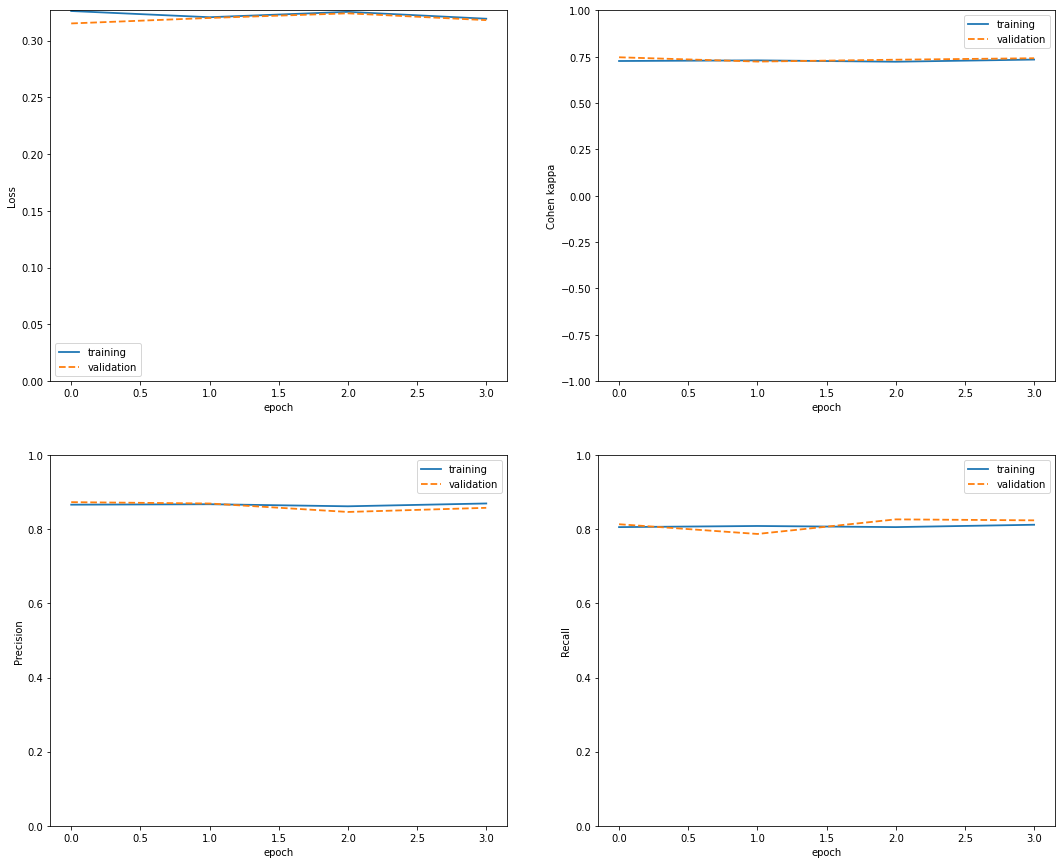

In [ ]:
plot_metrics(history)

In [ ]:
# fine-tuning: unfreeze the base model and train the entire model end-to-end with a low learning rate
model.get_layer('mobilenetv2_1.00_224').trainable = True

model.compile(
    optimizer=tf.keras.optimizers.Adam(
        1e-5
    ),  # we need small learning rate to avoid catastrophic forgetting
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=METRICS,
)

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2,259,265
Trainable params: 2,225,153
Non-trainable params: 34,112
_________________________________________________________________


In [ ]:
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss", #val_loss
    verbose=1,
    patience=1,
    mode="min",
    factor=0.1, #nhân 0.2 vào lr
    #min_lr=1e-10,
)

In [ ]:
checkpoint_filepath = '/content/gdrive/MyDrive/checkpoint' 
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

In [ ]:
history = model.fit(
    trainset,
    epochs=100,
    validation_data=validationset,
    callbacks=[early_stopping, reduce_lr_on_plateau],
    class_weight=clas_weights
)

Epoch 1/100
1098/1098 [==============================] - 307s 273ms/step - loss: 0.3532 - tp: 3135.0000 - fp: 538.0000 - tn: 5227.0000 - fn: 852.0000 - binary_acc: 0.8575 - precision: 0.8535 - recall: 0.7863 - f1_score: 0.8185 - roc_auc: 0.9169 - pr_auc: 0.9099 - cohen_kappa: 0.7015 - val_loss: 0.3599 - val_tp: 317.0000 - val_fp: 82.0000 - val_tn: 512.0000 - val_fn: 64.0000 - val_binary_acc: 0.8503 - val_precision: 0.7945 - val_recall: 0.8320 - val_f1_score: 0.8128 - val_roc_auc: 0.9220 - val_pr_auc: 0.9076 - val_cohen_kappa: 0.6881 - lr: 1.0000e-05
Epoch 2/100
1098/1098 [==============================] - ETA: 0s - loss: 0.3393 - tp: 2864.0000 - fp: 459.0000 - tn: 4712.0000 - fn: 742.0000 - binary_acc: 0.8632 - precision: 0.8619 - recall: 0.7942 - f1_score: 0.8267 - roc_auc: 0.9209 - pr_auc: 0.9167 - cohen_kappa: 0.7139
Epoch 2: ReduceLROnPlateau reducing learning rate to 9.999999747378752e-07.
1098/1098 [==============================] - 284s 259ms/step - loss: 0.3393 - tp: 2864.0000 

In [ ]:
model.save(
    f"/content/gdrive/MyDrive/mobilenet_imagenet-360(date 15.8 XR_WRIST).h5"
)


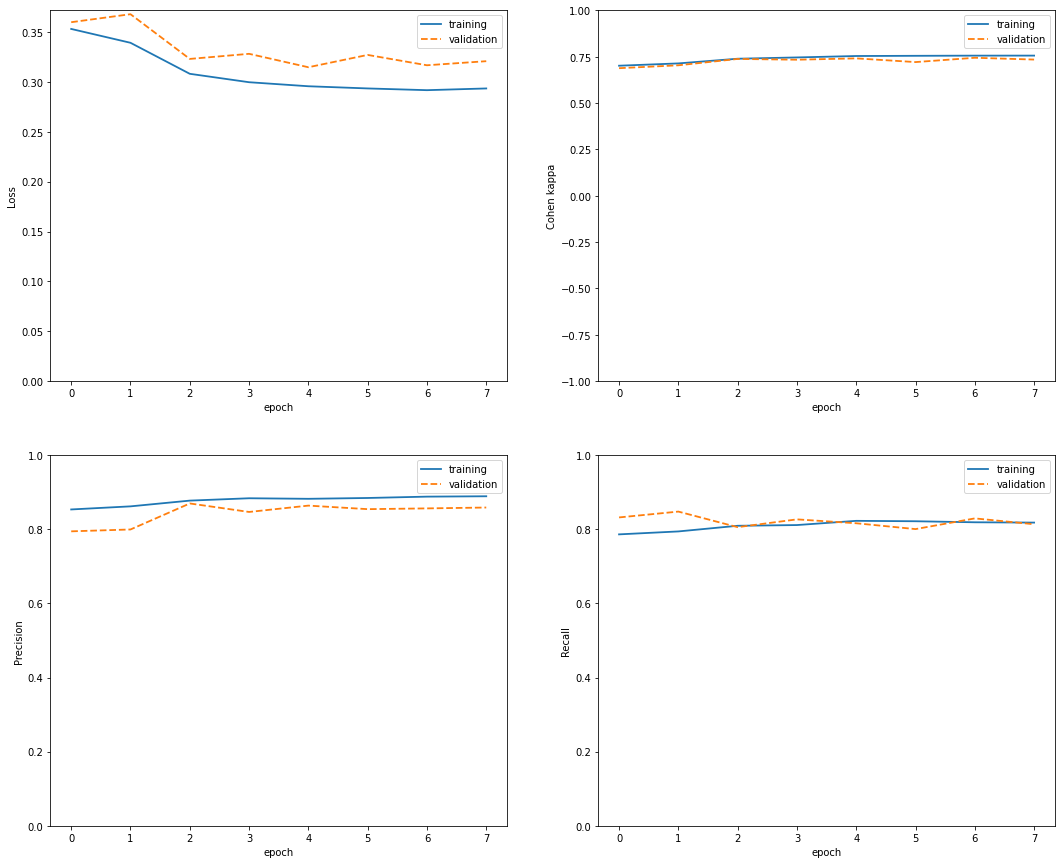

In [ ]:
plot_metrics(history)

In [ ]:
# get the loss value & metrics values for the model in validation mode
evaluation_metrics = model.evaluate(validationset, verbose=1)

122/122 [==============================] - 24s 198ms/step - loss: 0.3187 - tp: 311.0000 - fp: 46.0000 - tn: 548.0000 - fn: 70.0000 - binary_acc: 0.8810 - precision: 0.8711 - recall: 0.8163 - f1_score: 0.8428 - roc_auc: 0.9278 - pr_auc: 0.9155 - cohen_kappa: 0.7473


In [ ]:
loss = evaluation_metrics.pop(0)

print(f"val loss    : {loss}")
for metric, score in zip(METRICS, evaluation_metrics):

    print(f"{metric.name + ' ' * (12 - len(metric.name))}: {score}")

val loss    : 0.3187101185321808
tp          : 311.0
fp          : 46.0
tn          : 548.0
fn          : 70.0
binary_acc  : 0.8810256123542786
precision   : 0.8711484670639038
recall      : 0.8162729740142822
f1_score    : 0.8428184390068054
roc_auc     : 0.9277817606925964
pr_auc      : 0.9155369400978088
cohen_kappa : 0.7472715973854065


In [ ]:
'''clean_up(model)
clean_up(densenet)
13.6 10h sáng cohen_kappa : 0.60,
/content/gdrive/MyDrive/mobilenet_imagenet-360(date 13.6 2nd )
val loss    : 0.3861117660999298
tp          : 272.0
fp          : 39.0
tn          : 553.0
fn          : 122.0
binary_acc  : 0.836713969707489
precision   : 0.8745980858802795
recall      : 0.6903553009033203
roc_auc     : 0.8837353587150574
pr_auc      : 0.8760529160499573
cohen_kappa : 0.6472797393798828 dropout 0.5
/content/gdrive/MyDrive/mobilenet_imagenet-360(date 13.6 3nd ) ko dropout 
val loss    : 0.3759690225124359
tp          : 267.0
fp          : 31.0
tn          : 561.0
fn          : 127.0
binary_acc  : 0.8397566080093384
precision   : 0.8959731459617615
recall      : 0.6776649951934814
roc_auc     : 0.8917504549026489
pr_auc      : 0.8850770592689514
cohen_kappa : 0.6518610715866089
/content/gdrive/MyDrive/mobilenet_imagenet-360(date 19.6 ) thêm class weight
val loss    : 0.4006311297416687
tp          : 256.0
fp          : 20.0
tn          : 572.0
fn          : 138.0
binary_acc  : 0.8397566080093384
precision   : 0.9275362491607666
recall      : 0.6497461795806885
roc_auc     : 0.8719367384910583
pr_auc      : 0.8714836835861206
cohen_kappa : 0.6484388113021851

 '''

'clean_up(model)\nclean_up(densenet)\n13.6 10h sáng cohen_kappa : 0.60,\n/content/gdrive/MyDrive/mobilenet_imagenet-360(date 13.6 2nd )\nval loss    : 0.3861117660999298\ntp          : 272.0\nfp          : 39.0\ntn          : 553.0\nfn          : 122.0\nbinary_acc  : 0.836713969707489\nprecision   : 0.8745980858802795\nrecall      : 0.6903553009033203\nroc_auc     : 0.8837353587150574\npr_auc      : 0.8760529160499573\ncohen_kappa : 0.6472797393798828 dropout 0.5\n/content/gdrive/MyDrive/mobilenet_imagenet-360(date 13.6 3nd ) ko dropout \nval loss    : 0.3759690225124359\ntp          : 267.0\nfp          : 31.0\ntn          : 561.0\nfn          : 127.0\nbinary_acc  : 0.8397566080093384\nprecision   : 0.8959731459617615\nrecall      : 0.6776649951934814\nroc_auc     : 0.8917504549026489\npr_auc      : 0.8850770592689514\ncohen_kappa : 0.6518610715866089\n/content/gdrive/MyDrive/mobilenet_imagenet-360(date 19.6 ) thêm class weight\nval loss    : 0.4006311297416687\ntp          : 256.0\nf